## History
- 인터렉티브 한 시각화 결과보다는,
- 학습이 다 끝나야지만 그 결과를 바탕으로 볼 수 있다

In [1]:
import os
from glob import glob

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets

import matplotlib.pyplot as plt

%matplotlib inline

## Hyper parameter Tunning

In [2]:
num_epochs = 10
batch_size = 32
learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3,3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3,3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3,3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3,3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs = inputs, outputs = net)
model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0     

## Data Process

In [4]:
## (1) train, test 데이터 읽어오기
print(os.listdir('../dataset/cifar/'))

train_paths = glob('../dataset/cifar/train/*.png')[:1000]
test_paths = glob('../dataset/cifar/test/*.png')[:1000]

print(len(train_paths), len(test_paths))

## (2) label name 반환
def get_class_name(path):
    return path.split('_')[-1].replace('.png','')

## (3) label name 고유값 list - class_names
train_labels = [get_class_name(path) for path in train_paths] # 50000개
class_names = np.unique(train_labels) # 해당 class 개로 줄여짐

# (4) label 반환 onehot encoding 된 형태로 or argmax 로 해당 index
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot) 

# (5) 최종 image, label 반환
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32)/.255 # rescale
    
    label = get_label(path)
    return image, label

# (6) image preprocess (랜덤 Generator)
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE # 작동하는 Network가 스스로 설정하고 Dataset을 잘 불러올 수 있게 결정하라는 것


# train dataset 뽑기
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls = AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls = AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = len(train_paths))
train_dataset = train_dataset.repeat()

# test set 데이터 뽑기
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()
      

['labels.txt', 'test', 'train']
1000 1000


## Training

In [10]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch = steps_per_epoch,
    validation_data = test_dataset,
    validation_steps = validation_steps,
    epochs = num_epochs,
)

Epoch 1/10
31/31 [==============================] - 6s 186ms/step - loss: 2.3070 - accuracy: 0.1043 - val_loss: 2.3020 - val_accuracy: 0.0897
Epoch 2/10
31/31 [==============================] - 8s 269ms/step - loss: 2.3031 - accuracy: 0.1198 - val_loss: 2.3003 - val_accuracy: 0.0847
Epoch 3/10
31/31 [==============================] - 10s 333ms/step - loss: 2.2939 - accuracy: 0.1384 - val_loss: 2.2930 - val_accuracy: 0.0988
Epoch 4/10
31/31 [==============================] - 11s 363ms/step - loss: 2.3256 - accuracy: 0.1209 - val_loss: 2.2726 - val_accuracy: 0.1502
Epoch 5/10
31/31 [==============================] - 11s 350ms/step - loss: 2.2755 - accuracy: 0.1411 - val_loss: 2.2506 - val_accuracy: 0.1754
Epoch 6/10
31/31 [==============================] - 10s 337ms/step - loss: 2.2961 - accuracy: 0.1281 - val_loss: 2.2427 - val_accuracy: 0.1623
Epoch 7/10
31/31 [==============================] - 10s 321ms/step - loss: 2.2894 - accuracy: 0.1529 - val_loss: 2.2668 - val_accuracy: 0.1552
E

## History 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'verbose': 1, 'epochs': 10, 'steps': 31}


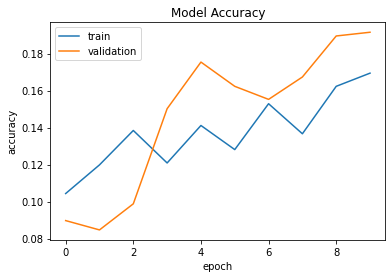

In [12]:
# history 는 기본적으로 dictionary로 담겻음
print(history.history.keys())

# parameter 등
print(history.params)

# history에서 model 꺼내서 predict도 가능
#new_model = history.model 
#history.predict() 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

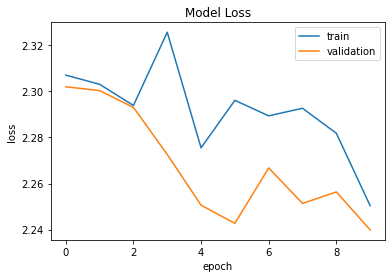

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()